# MODELO CLASIFICADOR - DATASET 2 AÑOS HIDRÁULICOS.

En el notebook *"Modelo_Clasificador_1.ipynb"* se veía como la variable PRECIO_MD_ESP tenía mucho peso en la mayoría de los modelos.

En el análisis previo, realizado con el notebook *Exploracion_datos.ipynb* guardado en la carpeta "Exploracion_datos", se detectaba que el año 1 contemplaba escenarios de precios muy inferiores a los otros dos años. A priori se decidió continuar con un dataset de 3 años, pensando en englobar el mayor número de escenarios de precios.

Sin embargo, lo que puede parecer una ventaja, puede estar distorsionando el resultado. Es decir, lo que en el ANHO1, en unas variables temporales cualesquiera, era considerado un precio horario elevado (por ejemplo), en el ANHO3 en la misma situación temporal podría ser un precio medio/bajo.

Repito el procedimiento anterior de entrenamiento de modelos, previa selección de hiperparámetros, para un dataset que va del 01/10/2016 al 30/09/2018 y analizaré qué tamaño es mejor para mi modelo.

**NOTA:** Cuando el modelo se encuentre en producción, se alimentará con nuevos datos, contemplando siempre años móviles, cada X tiempo y se entrenará de nuevo, como mantenimiento para adaptarse a los cambios que puedan suceder en el mercado.

**Librerías necesarias**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import altair as alt

%matplotlib inline
plt.style.use('ggplot')

#Librerías para modelos

#k-neighbors
from sklearn.neighbors import KNeighborsClassifier
#SVC
from sklearn.svm import SVC
#Arbol de decision
from sklearn.tree import DecisionTreeClassifier
#Regresión logística
from sklearn.linear_model import LogisticRegression
#Para agrupar clasificadores
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix, precision_score

#Para representar el arbol

import pydotplus
from IPython.display import Image
from sklearn import tree

In [2]:
pd.options.display.max_columns= None

Descarga de datos previamente procesados y almacenados en *data_processed/data_processed_definitive.csv* 

In [3]:
df=pd.read_csv('../data_processed/data_processed_definitive.csv',sep=';',index_col=False,parse_dates=['FECHA'])
df.head(3)

,FECHA,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA
0,2015-10-01,1,10,4,56.65,0,0,2196.1,24517.1,10060.7,326.43,3714,4909,1
1,2015-10-01,2,10,4,53.50,0,0,2064.4,23168.6,10060.7,307.80,3714,4909,0
2,2015-10-01,3,10,4,49.69,0,0,1866.5,22437.2,10060.7,298.16,3714,4909,0


In [5]:
df.dtypes

FECHA               datetime64[ns]
PERIODO                      int64
MES                          int64
WD                           int64
PRECIO_MD_ESP              float64
ACOPLADO_FR                  int64
RESERVA_D-1                  int64
P48_EOLICA                 float64
P48_DEMANDA                float64
POT_DISP_CARBON            float64
CARBON_D-1                 float64
EMB_ANUALES                  int64
EMB_HIPERANUALES             int64
RESERVA                      int64
dtype: object

Selecciono mi nuevo dataset:

In [9]:
df_new=df[df['FECHA']>'2016-09-30'].copy()
df_new.head()

,FECHA,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA
8783,2016-10-01,1,10,6,45.29,1,0,3774.1,24927.2,8137.2,338.99,3148,4491,1
8784,2016-10-01,2,10,6,40.85,0,0,3525.3,24005.4,7219.5,325.09,3148,4491,0
8785,2016-10-01,3,10,6,39.00,0,0,3210.3,22907.2,7219.5,296.65,3148,4491,0
8786,2016-10-01,4,10,6,37.94,0,0,2858.9,22339.2,7219.5,287.23,3148,4491,0
8787,2016-10-01,5,10,6,37.90,0,1,2648.1,21865.9,7219.5,274.12,3148,4491,0


Además, elimino la variable ACOPLADO_FR, al ver en el notebook *Modelo_Clasificador_2.ipynb* como no aporta nada a ninguno de los modelos.

In [10]:
df_new.drop('ACOPLADO_FR',axis=1,inplace=True)
df_new.head()

,FECHA,PERIODO,MES,WD,PRECIO_MD_ESP,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA
8783,2016-10-01,1,10,6,45.29,0,3774.1,24927.2,8137.2,338.99,3148,4491,1
8784,2016-10-01,2,10,6,40.85,0,3525.3,24005.4,7219.5,325.09,3148,4491,0
8785,2016-10-01,3,10,6,39.00,0,3210.3,22907.2,7219.5,296.65,3148,4491,0
8786,2016-10-01,4,10,6,37.94,0,2858.9,22339.2,7219.5,287.23,3148,4491,0
8787,2016-10-01,5,10,6,37.90,1,2648.1,21865.9,7219.5,274.12,3148,4491,0


In [11]:
df_new.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA
count,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000
mean,12.501085,6.526430,4.091449,53.950701,0.571526,5360.125351,28866.364522,8528.489742,320.065323,4284.092305,3440.335198,0.572211
std,6.922035,3.447941,2.026083,12.596575,0.494872,3141.636341,4662.260288,721.694227,47.023089,1450.442646,907.425576,0.494772
min,1.000000,1.000000,1.000000,2.060000,0.000000,240.800000,18277.400000,5693.700000,151.940000,2222.000000,2138.000000,0.000000
25%,7.000000,4.000000,2.000000,46.620000,0.000000,2934.325000,24887.500000,8089.200000,292.565000,3148.000000,2712.000000,0.000000
50%,13.000000,7.000000,4.000000,53.340000,1.000000,4691.350000,29062.500000,8618.500000,330.550000,4017.000000,3363.000000,1.000000
75%,18.750000,10.000000,6.000000,62.260000,1.000000,7130.150000,32480.400000,9128.800000,352.590000,5172.000000,4266.000000,1.000000
max,24.000000,12.000000,7.000000,101.990000,1.000000,16952.600000,41297.900000,9534.700000,517.780000,7092.000000,5004.000000,1.000000


### 1) Creo train_test_set

In [13]:
attributes_column = list(df_new.drop(['FECHA','RESERVA'],axis=1).columns)  #11 en total

In [14]:
X=df_new[attributes_column]
y=df_new['RESERVA']

Aplico train_test_split para separar aleatoriamente mi dataset en un set de entrenamiento y otro de test fijando la semilla y compruebo que ambos subconjuntos (train/test) son significativos del total

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_train.shape

(14014, 11)

In [17]:
X_test.shape

(3504, 11)

**Features**

In [18]:
X_train.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES
count,14014.000000,14014.000000,14014.000000,14014.000000,14014.000000,14014.000000,14014.000000,14014.000000,14014.000000,14014.000000,14014.000000
mean,12.478878,6.521835,4.093335,53.979276,0.570715,5340.711774,28876.317169,8532.410532,320.118353,4286.529685,3441.738975
std,6.921449,3.443054,2.018750,12.591399,0.494992,3136.525095,4666.643239,716.687666,46.930854,1447.392807,906.712491
min,1.000000,1.000000,1.000000,2.060000,0.000000,240.800000,18277.400000,5693.700000,151.940000,2222.000000,2138.000000
25%,6.000000,4.000000,2.000000,46.690000,0.000000,2919.100000,24899.225000,8089.200000,293.002500,3213.000000,2712.000000
50%,12.000000,7.000000,4.000000,53.380000,1.000000,4687.650000,29068.100000,8618.500000,330.665000,4017.000000,3421.000000
75%,18.000000,10.000000,6.000000,62.300000,1.000000,7085.750000,32519.475000,9128.800000,352.460000,5172.000000,4266.000000
max,24.000000,12.000000,7.000000,101.990000,1.000000,16952.600000,41297.900000,9534.700000,517.780000,7092.000000,5004.000000


In [19]:
X_test.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES
count,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000
mean,12.589897,6.544806,4.083904,53.836416,0.574772,5437.768579,28826.559618,8512.808818,319.853231,4274.344178,3434.720890
std,6.924652,3.467848,2.055422,12.618407,0.494448,3161.253637,4645.140561,741.276755,47.396328,1462.743950,910.379994
min,1.000000,1.000000,1.000000,2.300000,0.000000,454.400000,18501.100000,5693.700000,154.500000,2222.000000,2138.000000
25%,7.000000,4.000000,2.000000,46.460000,0.000000,3021.250000,24849.725000,8064.900000,290.617500,3148.000000,2560.000000
50%,13.000000,7.000000,4.000000,53.195000,1.000000,4711.250000,29016.450000,8617.800000,330.170000,4017.000000,3363.000000
75%,19.000000,10.000000,6.000000,62.102500,1.000000,7333.700000,32380.525000,9119.900000,352.960000,5172.000000,4143.000000
max,24.000000,12.000000,7.000000,100.670000,1.000000,16471.600000,40921.600000,9534.700000,504.980000,7092.000000,5004.000000


**Distribución de features**

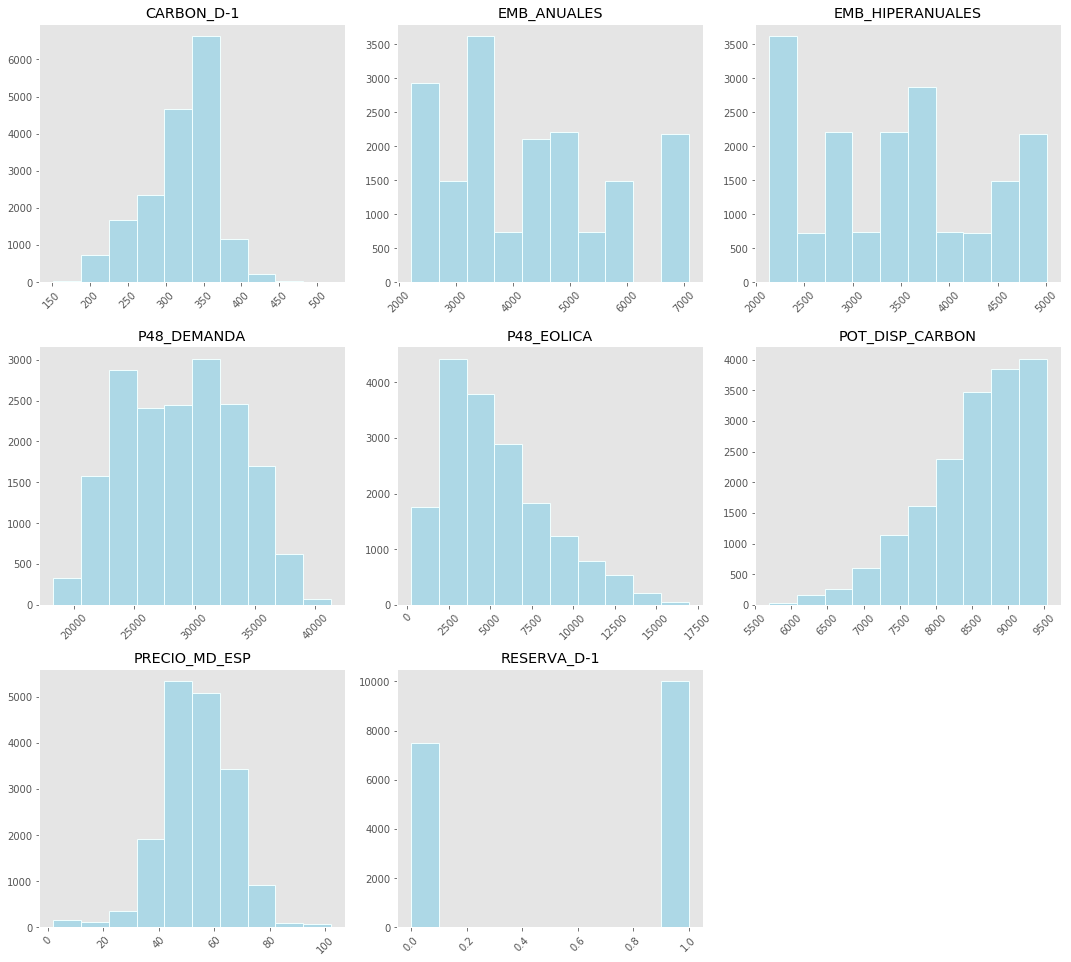

In [20]:
fig = X.drop(['MES','PERIODO','WD'],axis=1).hist(color='lightblue',
                                                    edgecolor='azure', linewidth=1.0,
                                                    xlabelsize=10, ylabelsize=10,
                                                    xrot=45, yrot=0,
                                                    figsize=(10,9),
                                                    grid=False)
plt.tight_layout(rect=(0, 0, 1.5, 1.5))  

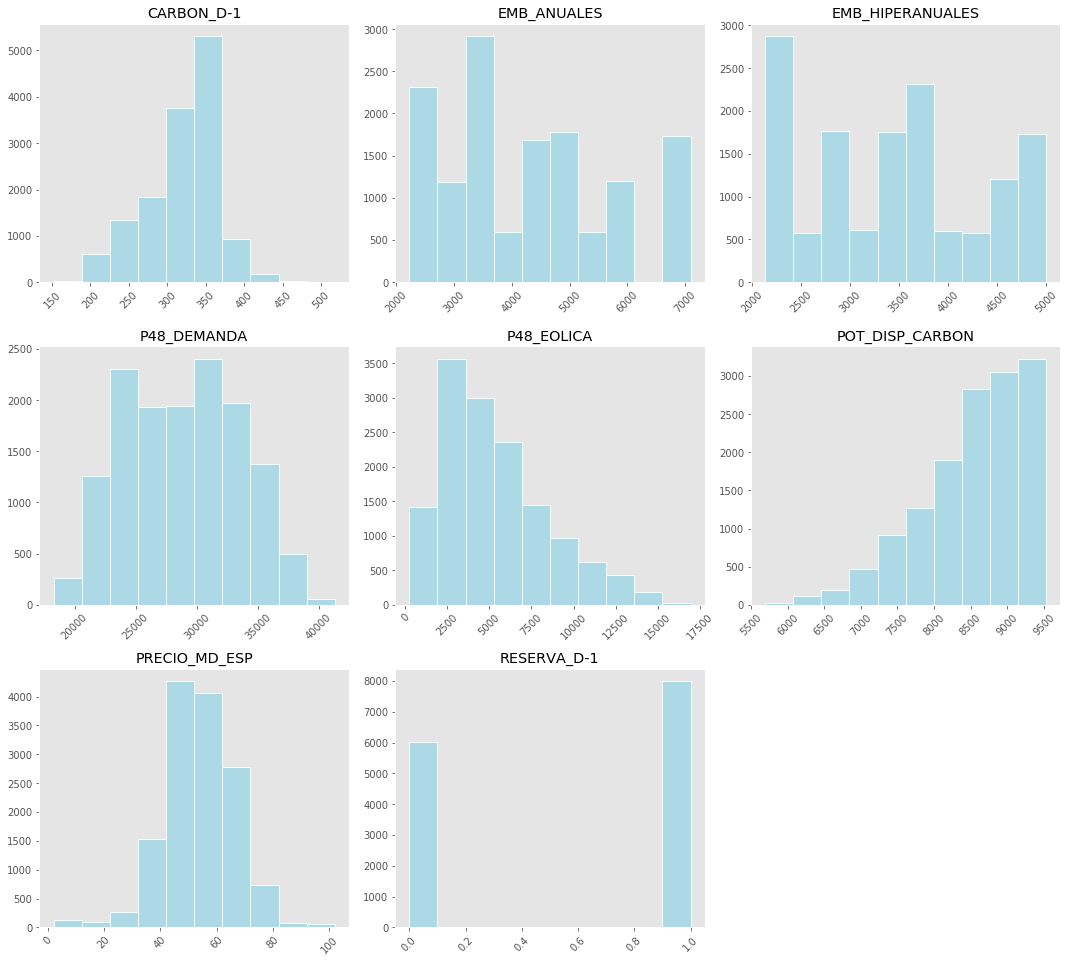

In [21]:
fig = X_train.drop(['MES','PERIODO','WD'],axis=1).hist(color='lightblue',
                                                    edgecolor='azure', linewidth=1.0,
                                                    xlabelsize=10, ylabelsize=10,
                                                    xrot=45, yrot=0,
                                                    figsize=(10,9),
                                                    grid=False)
plt.tight_layout(rect=(0, 0, 1.5, 1.5))  

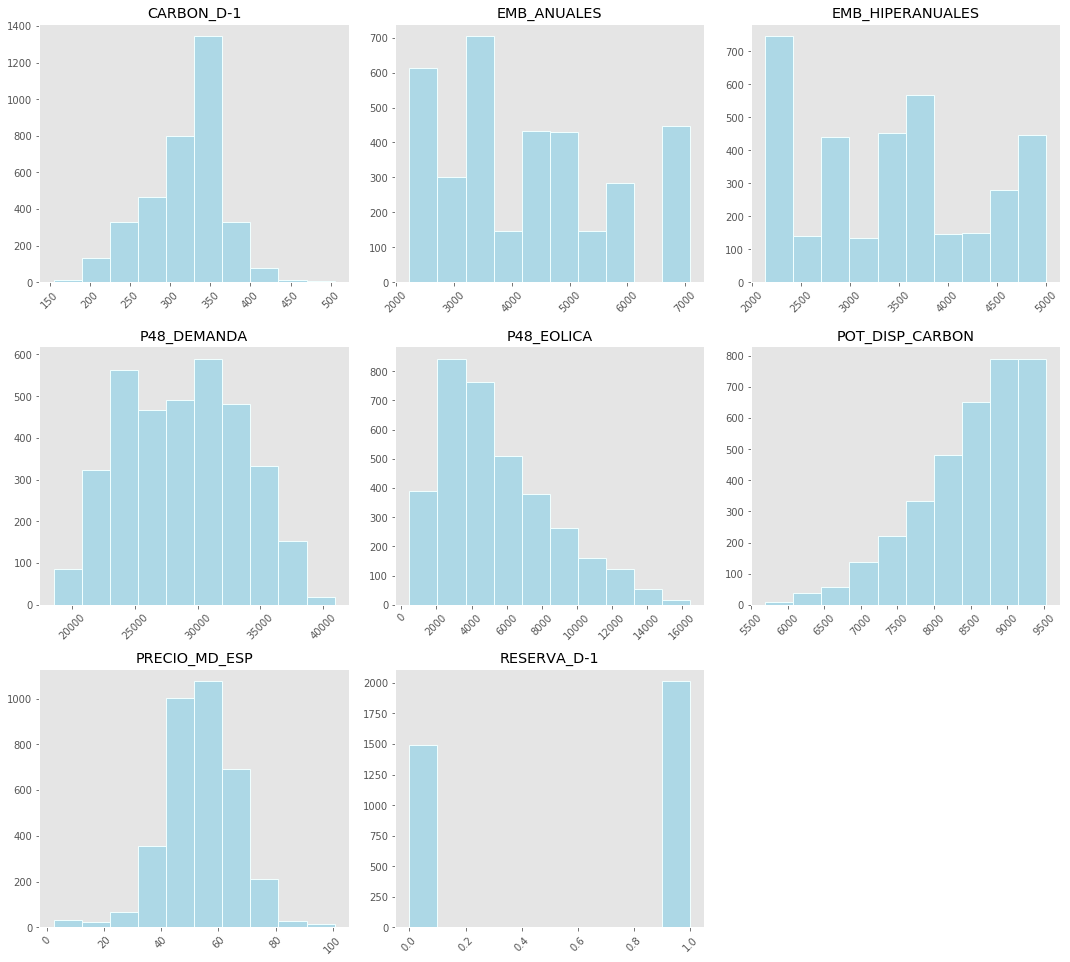

In [22]:
fig = X_test.drop(['MES','PERIODO','WD'],axis=1).hist(color='lightblue',
                                                    edgecolor='azure', linewidth=1.0,
                                                    xlabelsize=10, ylabelsize=10,
                                                    xrot=45, yrot=0,
                                                    figsize=(10,9),
                                                    grid=False)
plt.tight_layout(rect=(0, 0, 1.5, 1.5))  

**Comportamiento target RESERVA**

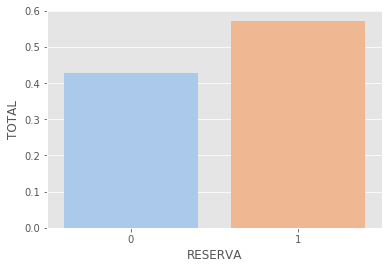

RESERVA=1: 0.572


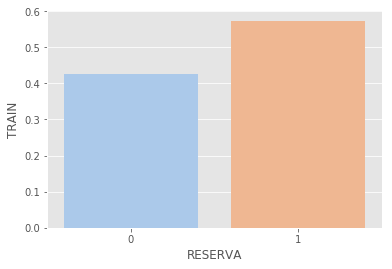

RESERVA=1: 0.574


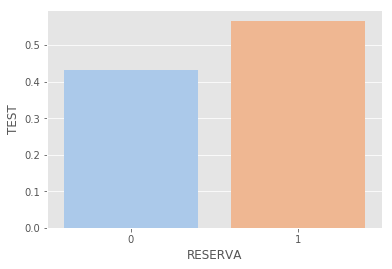

RESERVA=1: 0.567


In [23]:
PORC=y.value_counts(normalize=True,sort=False).reset_index()
PORC.columns=(['RESERVA','TOTAL'])
PORC['TRAIN']=y_train.value_counts(normalize=True,sort=False).values
PORC['TEST']=y_test.value_counts(normalize=True,sort=False).values

sns.barplot(x='RESERVA',y='TOTAL',data=PORC,palette='pastel');
plt.show()
print('RESERVA=1: %.3f' %PORC['TOTAL'].loc[1])

sns.barplot(x='RESERVA',y='TRAIN',data=PORC,palette='pastel');
plt.show()
print('RESERVA=1: %.3f' %PORC['TRAIN'].loc[1])

sns.barplot(x='RESERVA',y='TEST',data=PORC,palette='pastel');
plt.show()
print('RESERVA=1: %.3f' %PORC['TEST'].loc[1])

### 2) Pruebo diferentes modelos

Utilizo **GridSearchCV** para ajustar hiperparámetros.

Como métrica utilizo **accuracy**: porcentaje total de los aciertos del modelo.


#### a) KNN

In [25]:
clfk=GridSearchCV(KNeighborsClassifier(n_neighbors=1),
                 param_grid={"n_neighbors": [3,5,7,15,100]},
                 scoring="accuracy",
                 cv=10)

clfk.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 15, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [26]:
clfk.best_params_

{'n_neighbors': 3}

In [27]:
clfk.best_score_

0.6431425717140002

In [29]:
clfk_3=clfk.best_estimator_

In [30]:
clfk_3.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [32]:
accuracy_score(y_test, clfk_3.predict(X_test))

0.6521118721461188

#### b) SVC

In [34]:
clfsvc=GridSearchCV(SVC(kernel="rbf",C=1,gamma=1,random_state=42),  
                 param_grid={"gamma": [10,100,1000,10000],"C":[0.1,1,10]},    
                 scoring="accuracy",
                 cv=5)
clfsvc.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [10, 100, 1000, 10000], 'C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [35]:
clfsvc.best_params_

{'C': 0.1, 'gamma': 10}

In [36]:
clfsvc.best_score_

0.5735692878550022

In [37]:
clfsvc_3=clfsvc.best_estimator_

In [38]:
clfsvc_3.fit(X_train,y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
accuracy_score(y_test, clfsvc_3.predict(X_test))

0.5667808219178082

#### c) Decission Tree

In [41]:
clfd = GridSearchCV(DecisionTreeClassifier(min_samples_leaf=20,max_depth=3,random_state=42),
                            param_grid={"min_samples_leaf": [10,20,30,50,100,150,200,250], "max_depth":range(2,7)},
                               scoring="accuracy",
                               cv=10)
clfd.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [10, 20, 30, 50, 100, 150, 200, 250], 'max_depth': range(2, 7)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [42]:
clfd.best_params_

{'max_depth': 6, 'min_samples_leaf': 50}

In [43]:
clfd.best_score_

0.6330812045097759

In [44]:
clfd_3=clfd.best_estimator_

In [45]:
clfd_3.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

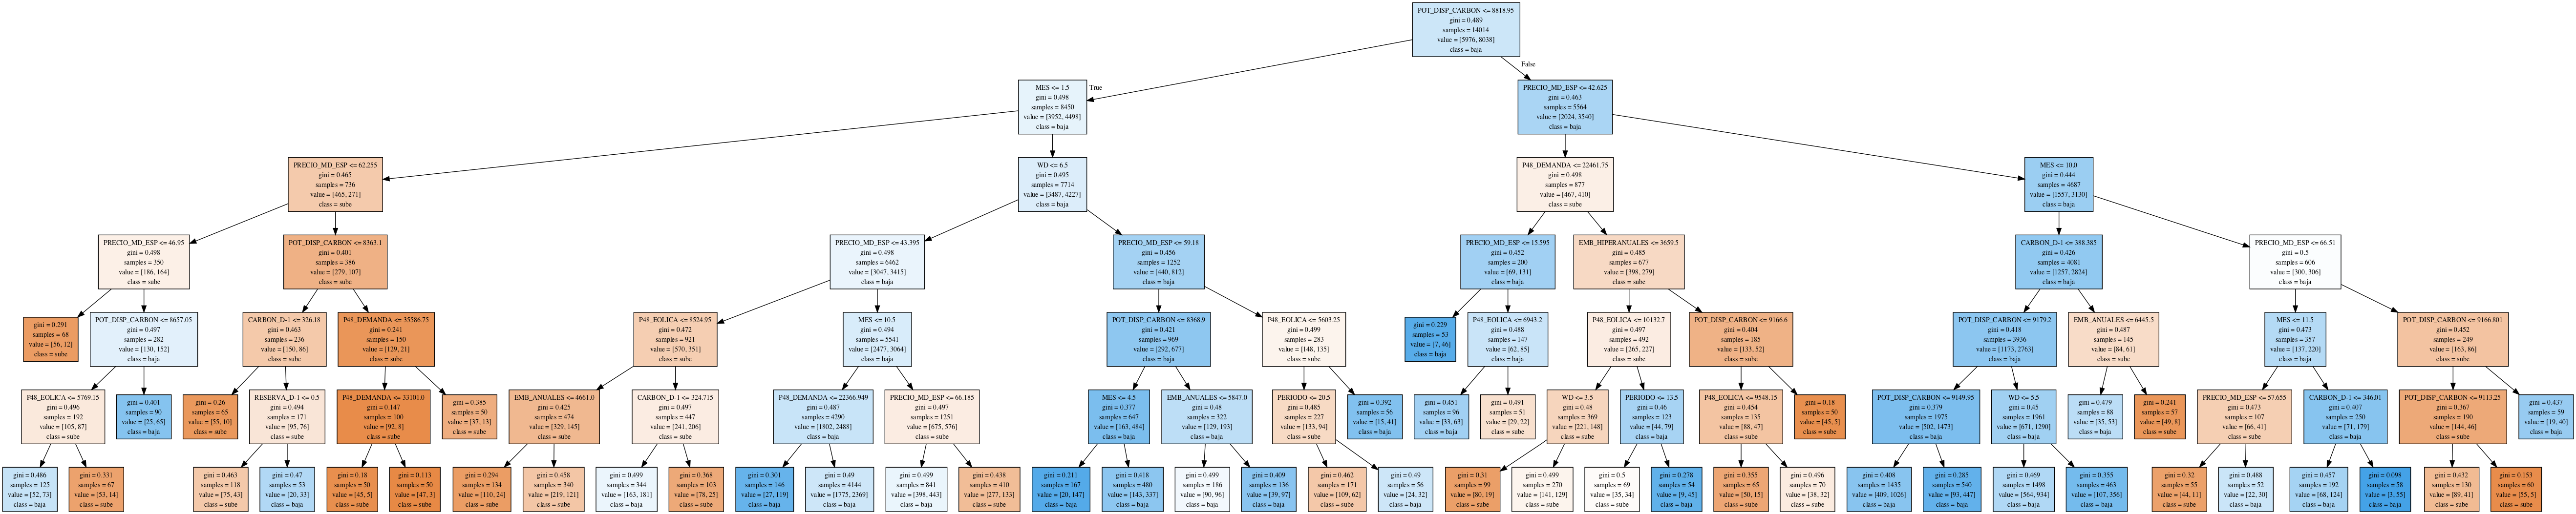

In [46]:
dot_data = tree.export_graphviz(clfd_3,
                                out_file=None, 
                                filled=True,                           #filled le pone un color en funcion de la clase
                                feature_names=attributes_column,
                                class_names=["sube","baja"])            

graph=pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [47]:
accuracy_score(y_test, clfd_3.predict(X_test))

0.6289954337899544

In [48]:
importances = clfd_3.feature_importances_

indices = np.argsort(importances)[::-1]

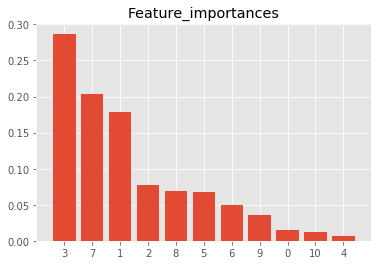

['PRECIO_MD_ESP', 'POT_DISP_CARBON', 'MES', 'WD', 'CARBON_D-1', 'P48_EOLICA', 'P48_DEMANDA', 'EMB_ANUALES', 'PERIODO', 'EMB_HIPERANUALES', 'RESERVA_D-1']


In [49]:
plt.figure()
plt.title("Feature_importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list([attributes_column[i] for i in indices]))

#### d) Random Forest

In [51]:
clfr = GridSearchCV(RandomForestClassifier(n_estimators=200, oob_score=True,random_state=42),
                          param_grid={"min_samples_leaf": [10, 20, 30, 50, 100, 150, 200, 250,500],
                                      'max_depth': range(2, 7, 500),
                                      'n_estimators': [100, 200, 500]},
                          scoring="accuracy",
                          cv=10)
clfr.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [10, 20, 30, 50, 100, 150, 200, 250, 500], 'max_depth': range(2, 7, 500), 'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [52]:
clfr.best_params_

{'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 100}

In [53]:
clfr.best_score_

0.5832025117739403

In [54]:
clfr_3=clfr.best_estimator_

In [55]:
clfr_3.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

**Ejemplo de árboles que lo forman (500):**

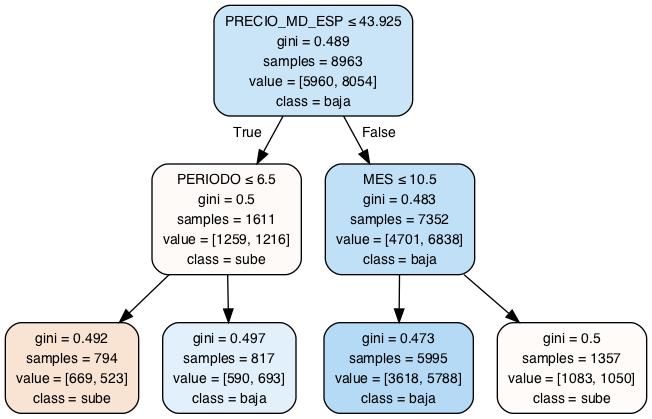

In [56]:
dot_data = tree.export_graphviz(clfr_3.estimators_[25], out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True,
                         feature_names=attributes_column,
                         class_names=["sube","baja"])  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png()) 

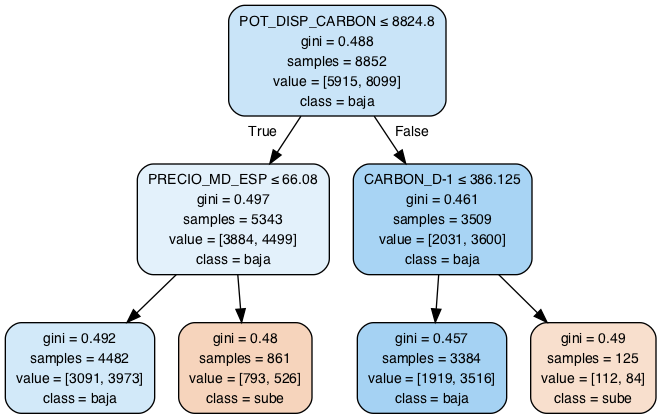

In [58]:
dot_data = tree.export_graphviz(clfr_3.estimators_[3], out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True,
                         feature_names=attributes_column,
                         class_names=["sube","baja"])  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png()) 

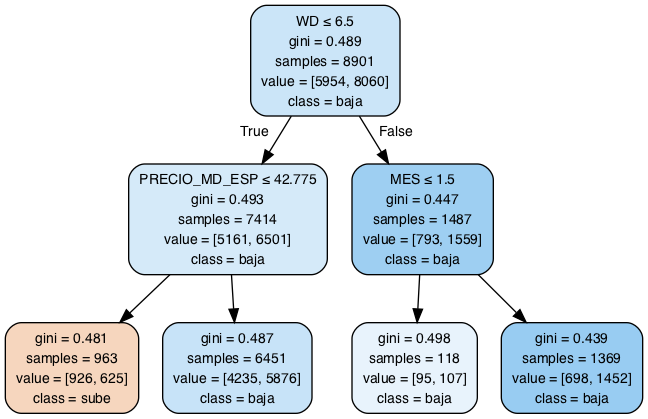

In [59]:
dot_data = tree.export_graphviz(clfr_3.estimators_[98], out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True,
                         feature_names=attributes_column,
                         class_names=["sube","baja"])  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png()) 

In [60]:
accuracy_score(y_test, clfr_3.predict(X_test))

0.5730593607305936

In [61]:
importances = clfr_3.feature_importances_

indices = np.argsort(importances)[::-1]

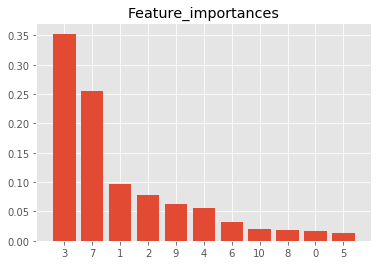

['PRECIO_MD_ESP', 'POT_DISP_CARBON', 'MES', 'WD', 'EMB_ANUALES', 'RESERVA_D-1', 'P48_DEMANDA', 'EMB_HIPERANUALES', 'CARBON_D-1', 'PERIODO', 'P48_EOLICA']


In [62]:
plt.figure()
plt.title("Feature_importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list([attributes_column[i] for i in indices]))

**NOTA:** Impactan notablemente más en el modelo el PRECIO_MD_ESP y POT_DISP_CARBON frente al resto de features. La variable MES, que fue objeto de estudio en el notebook *Exploracion_datos.ipynb* y se decidió considerarla, tiene un peso importante en este módelo y en el anterior de árbol de decisión (3ª posición en el ranking)

#### e) XGBOOST

In [64]:
clfxb = GridSearchCV(XGBClassifier(n_estimators=100,random_state=42),
                    param_grid={'n_estimators': [100, 200, 500]},
                    scoring="accuracy",
                    cv=5)
clfxb.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [65]:
clfxb.best_params_

{'n_estimators': 500}

In [66]:
clfxb.best_score_

0.6998715570144142

In [67]:
clfxb_3=clfxb.best_estimator_

In [68]:
clfxb_3.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [69]:
accuracy_score(y_test, clfxb_3.predict(X_test))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7040525114155252

In [70]:
importances = clfxb_3.feature_importances_

indices = np.argsort(importances)[::-1]

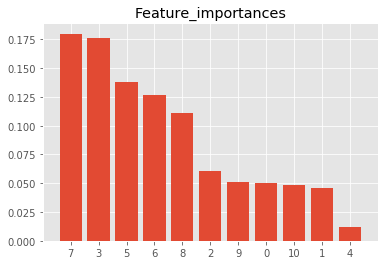

['POT_DISP_CARBON', 'PRECIO_MD_ESP', 'P48_EOLICA', 'P48_DEMANDA', 'CARBON_D-1', 'WD', 'EMB_ANUALES', 'PERIODO', 'EMB_HIPERANUALES', 'MES', 'RESERVA_D-1']


In [71]:
plt.figure()
plt.title("Feature_importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list([attributes_column[i] for i in indices]))

**NOTA:** En este caso la variable MES se pone en cola en cuanto a importancia en el modelo y resaltan 5 features sobre las demás: POT_DISP_CARBON, PRECIO_MD_ESP_, P48_EOLICA, P48_DEMANDA, CARBON_D-1.

#### f) Bagging

In [73]:
clfb = GridSearchCV(BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),n_estimators=100,oob_score=True,random_state=42),
                    param_grid={"n_estimators": [100, 200, 500]},
                    scoring="accuracy",
                    cv=5)
clfb.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=True,
         random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [74]:
clfb.best_score_

0.6449265020693592

In [75]:
clfb.best_params_

{'n_estimators': 500}

In [76]:
clfb_3=clfb.best_estimator_
clfb_3.fit(X_train,y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=1, oob_score=True,
         random_state=42, verbose=0, warm_start=False)

In [77]:
accuracy_score(y_test, clfb_3.predict(X_test))

0.6523972602739726

### 3) Análisis de resultados:

In [78]:
modelos=[clfk_3,clfsvc_3,clfd_3,clfr_3,clfxb_3,clfb_3]

Traigo resultados obtenidos en *Modelo_Clasificador_2.ipynb* para comparar:

In [90]:
modelos2=[]
names2= ['clfk_2','clfsvc_2','clfd_2','clfr_2','clfxb_2','clfb_2']
path2='/Users/blancabengoa/Desktop/KSchool/TFM/Modelo2/'

for k,n in enumerate(names2):
    modelos2.append(pickle.load(open(path2 + str(n) +".pkl","rb")))

Me traigo también X_test guardado de Modelo2 ya que, de utilizar el dataset seleccionado en este caso, podría estar usando como test datos que se utilizaron para el entrenamiento de Modelo2, y obtener unos engañosos falsos resultados. Quiero comparar los nuevos resultados con los reports obtenidos en el notebook anterior en el que se utilizaba un dataset de 3 años.

In [96]:
X_test2=pickle.load(open(path2 + "X_test.pkl","rb"))
y_test2=pickle.load(open(path2 + "y_test.pkl","rb"))

In [97]:
X_test2.head()

,PERIODO,MES,WD,PRECIO_MD_ESP,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES
18303,18,11,7,51.47,0,5128.7,23559.8,8081.6,350.85,2222,2182
24612,16,7,7,61.15,0,1900.9,26608.3,9495.0,343.00,5726,4521
2973,22,2,1,55.55,1,1620.7,34739.3,9393.2,313.92,6078,5988
22501,17,4,3,42.08,1,6711.6,30367.2,8181.4,414.50,7076,4822
4699,21,4,3,28.40,1,6437.3,31333.7,7831.9,294.38,6841,6339


In [100]:
X_test2.shape

(5261, 11)

In [99]:
y_test2.shape

(5261,)

**Clasification Report**

In [101]:
for k,m in enumerate(modelos):
    print('Modelo ' + list(str(m).split("("))[0] + '\n')
    print(classification_report(y_test,m.predict(X_test)) , classification_report(y_test2,modelos2[k].predict(X_test2)))

Modelo KNeighborsClassifier

             precision    recall  f1-score   support

          0       0.60      0.58      0.59      1518
          1       0.69      0.71      0.70      1986

avg / total       0.65      0.65      0.65      3504
              precision    recall  f1-score   support

          0       0.60      0.55      0.57      2258
          1       0.68      0.72      0.70      3003

avg / total       0.64      0.65      0.64      5261

Modelo SVC



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check t

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1518
          1       0.57      1.00      0.72      1986

avg / total       0.32      0.57      0.41      3504
              precision    recall  f1-score   support

          0       0.00      0.00      0.00      2258
          1       0.57      1.00      0.73      3003

avg / total       0.33      0.57      0.41      5261

Modelo DecisionTreeClassifier

             precision    recall  f1-score   support

          0       0.67      0.29      0.40      1518
          1       0.62      0.89      0.73      1986

avg / total       0.64      0.63      0.59      3504
              precision    recall  f1-score   support

          0       0.62      0.23      0.33      2258
          1       0.61      0.89      0.72      3003

avg / total       0.61      0.61      0.56      5261

Modelo RandomForestClassifier

             precision    recall  f1-score   support

          0       0.78  

* Los modelos que mejores resultados arrojan son XGBoost, KNeighbors, DecisionTree y BaggingClassifier,ligeramente mejores en este 2º caso (2 años hidráulicos más recientes).

* Al igual que ocurría desde la primera prueba de entrenamiento, el modelo SVM siempre predice 1 -> descartado.

* RandomForest tampoco predice bien y vuelve a predecir en la mayoría de casos bajada de intradiario (recall(0)=0, recall(1)=1)

In [104]:
for k,m in enumerate(modelos):
    print('Precision: \n' + list(str(m).split("("))[0])
    print('%.2f' %precision_score(y_test,m.predict(X_test)) + ', %.2f' %precision_score(y_test2,modelos2[k].predict(X_test2))  + '\n')

for k,m in enumerate(modelos):
    print('Accuracy: \n' + list(str(m).split("("))[0])
    print('%.2f' %accuracy_score(y_test,m.predict(X_test)) + ', %.2f' %accuracy_score(y_test2,modelos2[k].predict(X_test2)) + '\n')

Precision: 
KNeighborsClassifier
0.69, 0.68

Precision: 
SVC
0.57, 0.57

Precision: 
DecisionTreeClassifier
0.62, 0.61

Precision: 
RandomForestClassifier
0.57, 0.58

Precision: 
XGBClassifier
0.71, 0.70

Precision: 
BaggingClassifier


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.69, 0.68

Accuracy: 
KNeighborsClassifier
0.65, 0.65

Accuracy: 
SVC
0.57, 0.57

Accuracy: 
DecisionTreeClassifier
0.63, 0.61

Accuracy: 
RandomForestClassifier
0.57, 0.58

Accuracy: 
XGBClassifier
0.70, 0.70

Accuracy: 
BaggingClassifier


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.65, 0.65



En los modelos que nos interesan, aunque la diferencia es pequeña, es mejor quedarse con 2 años.

**Matriz de Confusión**

In [116]:
plt.subplot?

Signature: plt.subplot(*args, **kwargs)
Docstring:
Return a subplot axes at the given grid position.

Call signature::

   subplot(nrows, ncols, index, **kwargs)

In the current figure, create and return an `.Axes`, at position *index*
of a (virtual) grid of *nrows* by *ncols* axes.  Indexes go from 1 to
``nrows * ncols``, incrementing in row-major order.

If *nrows*, *ncols* and *index* are all less than 10, they can also be
given as a single, concatenated, three-digit number.

For example, ``subplot(2, 3, 3)`` and ``subplot(233)`` both create an
`.Axes` at the top right corner of the current figure, occupying half of
the figure height and a third of the figure width.

.. note::

   Creating a subplot will delete any pre-existing subplot that overlaps
   with it beyond sharing a boundary::

      import matplotlib.pyplot as plt
      # plot a line, implicitly creating a subplot(111)
      plt.plot([1,2,3])
      # now create a subplot which represents the top plot of a grid
      # wi

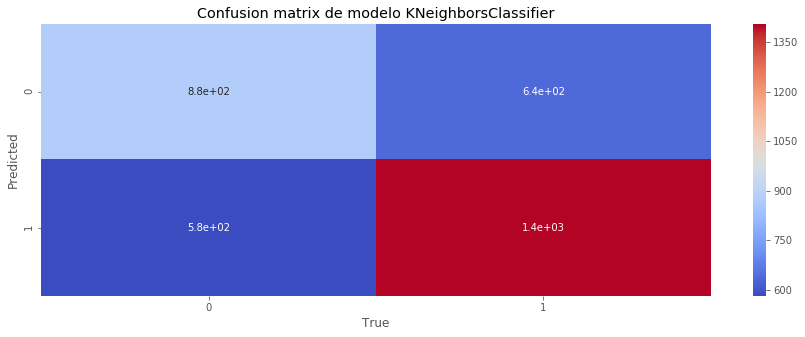

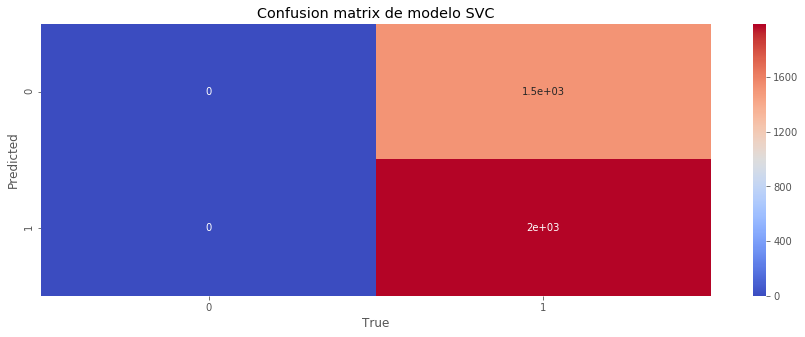

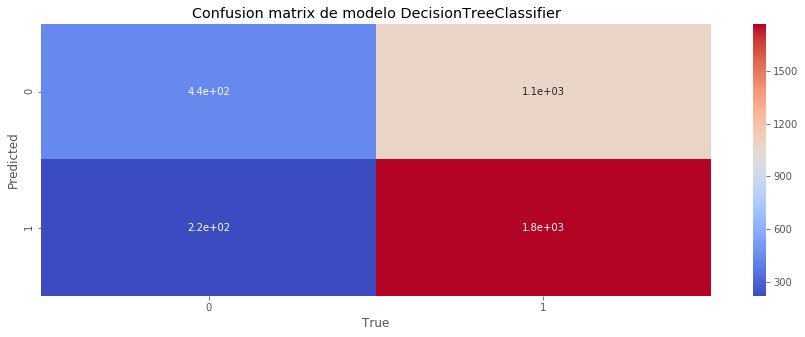

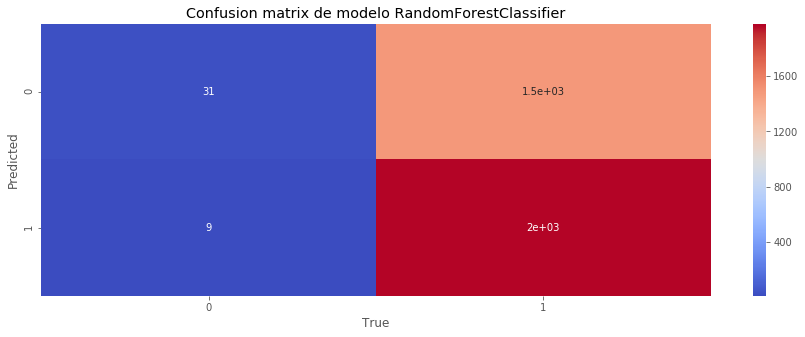

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


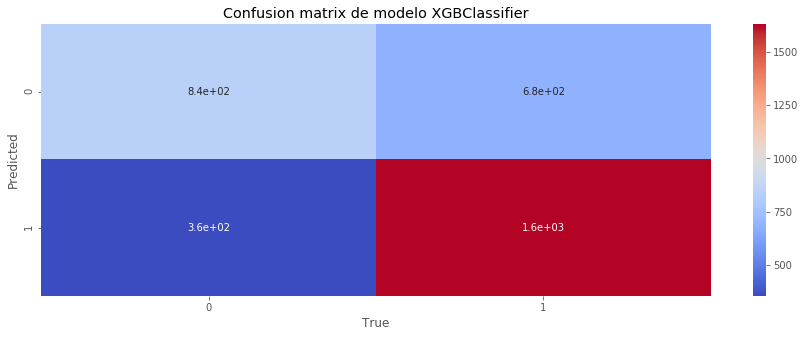

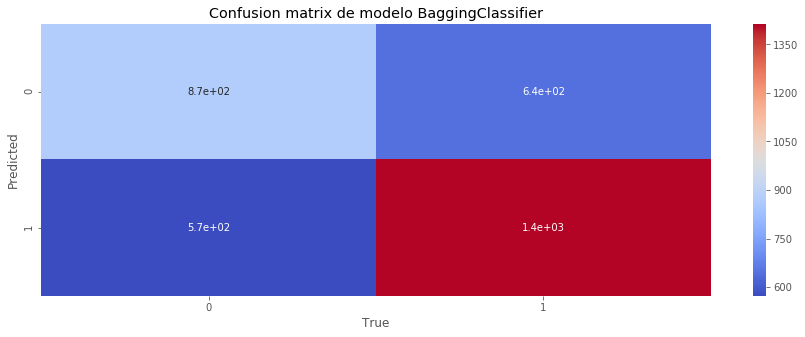

In [131]:
for k,m in enumerate(modelos):
    plt.figure(figsize=(15,5))
    cmatrix=confusion_matrix(y_test,m.predict(X_test))
    sns.heatmap(data = cmatrix, 
                annot=True,
                xticklabels=[0,1], 
                yticklabels=[0,1],
                cmap='coolwarm')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.title('Confusion matrix de modelo ' + list(str(m).split("("))[0])
    plt.show()

De todos, el mejor modelo continúa siendo **XGBoost**

Guardo los modelos obtenidos (ya entrenados) y la división del train_test_set.

**NOTA: Originalmente los guardo en una carpeta fuera de mi repositorio porque pesan mucho (sobretodo BaggingClassifier) y no quiero subirlos todos a github. Cuando haga la selección será lo que guarde y suba a git.**

Si se quieren guardar estos modelos para hacer cualquier prueba, escribir en *path* la ruta local donde se quieran almacenar.

In [132]:
names=['clfk_3','clfsvc_3','clfd_3','clfr_3','clfxb_3','clfb_3']

path='/Users/blancabengoa/Desktop/KSchool/TFM/Modelo3/'   #Aqui es donde debo poner la ruta especifica

In [133]:
for k,m in enumerate(modelos):
    
    pickle.dump(m,open(path + names[k] +".pkl","wb"))

In [134]:
#set de datos
pickle.dump(X_train,open(path + "X_train.pkl","wb"))
pickle.dump(y_train,open(path + "y_train.pkl","wb"))
pickle.dump(X_test,open(path + "X_test.pkl","wb"))
pickle.dump(y_test,open(path + "y_test.pkl","wb"))